Data Loaded Successfully. Shape: (50, 7)
             Name  Matric_Marks  Inter_Marks Preferred_Subject  Interest_Area  \
0      Ahmed Khan           900          920           Biology  Life Sciences   
1      Fatima Ali           880          890       Agriculture  Life Sciences   
2  Mohammed Iqbal           860          870           Biology  Life Sciences   
3     Aisha Malik           870          880       Agriculture  Life Sciences   
4  Zainab Hussain           820          830           Physics  Life Sciences   

   Entry_Test_Score Recommended_Department  
0                85                    DVM  
1                82                    DVM  
2                80                    DVM  
3                83                    DVM  
4                75                    DVM  
Encoded Columns Added:
  Preferred_Subject  Preferred_Subject_Encoded  Interest_Area  \
0           Biology                          1  Life Sciences   
1       Agriculture                          0  L

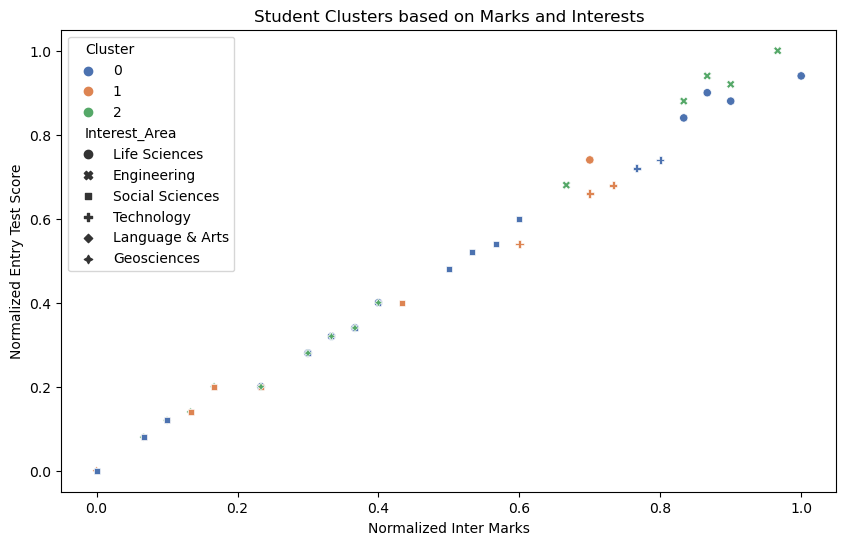

Cluster Counts:
Cluster
0    23
2    14
1    13
Name: count, dtype: int64
Recommendation Sample:
             Name Preferred_Subject  Entry_Test_Score Recommended_Department  \
0      Ahmed Khan           Biology              0.94                    DVM   
1      Fatima Ali       Agriculture              0.88                    DVM   
2  Mohammed Iqbal           Biology              0.84                    DVM   
3     Aisha Malik       Agriculture              0.90                    DVM   
4  Zainab Hussain           Physics              0.74                    DVM   
5     Omar Farooq           Physics              1.00   BS Civil Engineering   
6      Sara Ahmed              Math              0.94   BS Civil Engineering   
7     Usman Tariq           Physics              0.88   BS Civil Engineering   
8       Hina Butt              Math              0.92   BS Civil Engineering   
9  Khalid Mehmood  Computer Science              0.68   BS Civil Engineering   

   Suggested_Departmen

In [2]:
 %matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import os
warnings.filterwarnings('ignore')

# Step 3: Data Preprocessing
# Loading and cleaning the dataset
def load_and_clean_data():
    try:
        # Load the CSV file
        df = pd.read_csv('LUAWMS_Student_Data_50.csv')
        # Remove any blank or missing values
        df.dropna(inplace=True)
        # Verify data loaded correctly
        print("Data Loaded Successfully. Shape:", df.shape)
        print(df.head())
        return df
    except FileNotFoundError:
        print("Error: 'LUAWMS_Student_Data_50.csv' not found. Ensure the file is in the notebook's directory.")
        return None

# Encoding categorical features
def encode_features(df):
    # Copy dataframe to avoid modifying original
    df_encoded = df.copy()
    
    # Label encode categorical columns
    le_subject = LabelEncoder()
    le_interest = LabelEncoder()
    le_department = LabelEncoder()
    
    df_encoded['Preferred_Subject_Encoded'] = le_subject.fit_transform(df['Preferred_Subject'])
    df_encoded['Interest_Area_Encoded'] = le_interest.fit_transform(df['Interest_Area'])
    df_encoded['Recommended_Department_Encoded'] = le_department.fit_transform(df['Recommended_Department'])
    
    # Save encoders for potential inverse transformation
    encoders = {
        'subject': le_subject,
        'interest': le_interest,
        'department': le_department
    }
    
    print("Encoded Columns Added:")
    print(df_encoded[['Preferred_Subject', 'Preferred_Subject_Encoded', 
                     'Interest_Area', 'Interest_Area_Encoded', 
                     'Recommended_Department', 'Recommended_Department_Encoded']].head())
    
    return df_encoded, encoders

# Normalize numerical features
def normalize_features(df_encoded):
    scaler = MinMaxScaler()
    numerical_cols = ['Matric_Marks', 'Inter_Marks', 'Entry_Test_Score']
    df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])
    
    print("Normalized Numerical Features:")
    print(df_encoded[numerical_cols].head())
    return df_encoded

# Step 4: K-Means Clustering
def apply_clustering(df_encoded):
    # Features for clustering
    features = ['Matric_Marks', 'Inter_Marks', 'Entry_Test_Score', 
                'Preferred_Subject_Encoded', 'Interest_Area_Encoded']
    X = df_encoded[features]
    
    # Apply K-Means with 3 clusters (e.g., Science, Commerce, Arts)
    kmeans = KMeans(n_clusters=3, random_state=42)
    df_encoded['Cluster'] = kmeans.fit_predict(X)
    
    # Visualize clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_encoded, x='Inter_Marks', y='Entry_Test_Score', 
                    hue='Cluster', palette='deep', style='Interest_Area')
    plt.title('Student Clusters based on Marks and Interests')
    plt.xlabel('Normalized Inter Marks')
    plt.ylabel('Normalized Entry Test Score')
    plt.savefig('student_clusters.png')
    plt.show()
    
    print("Cluster Counts:")
    print(df_encoded['Cluster'].value_counts())
    
    return df_encoded, kmeans

# Step 5: Recommendation Logic
def recommend_department(row, encoders):
    # Simple if-else logic based on subject and marks
    subject = encoders['subject'].inverse_transform([int(row['Preferred_Subject_Encoded'])])[0]
    inter_marks = row['Inter_Marks']  # Normalized between 0 and 1
    entry_score = row['Entry_Test_Score']
    
    # Denormalize for readable logic (assuming original scale was 0-1000 for marks, 0-100 for score)
    inter_marks_original = inter_marks * 1000
    entry_score_original = entry_score * 100
    
    if subject in ['Biology', 'Agriculture'] and entry_score_original > 70:
        return 'DVM'
    elif subject in ['Physics', 'Math'] and entry_score_original > 80:
        return 'BS Civil Engineering'
    elif subject == 'Computer Science' and entry_score_original > 70:
        return 'BS Computer Science'
    elif subject == 'Economics' and entry_score_original > 60:
        return 'BBA'
    elif subject == 'English' and entry_score_original > 40:
        return 'BS English'
    elif subject == 'Sociology' and entry_score_original > 40:
        return 'BS Sociology'
    elif subject == 'Geology' and entry_score_original > 50:
        return 'BS Geology'
    else:
        return 'BS General Studies'

# Apply recommendations to all students
def apply_recommendations(df_encoded, encoders):
    df_encoded['Suggested_Department'] = df_encoded.apply(
        lambda row: recommend_department(row, encoders), axis=1)
    
    print("Recommendation Sample:")
    print(df_encoded[['Name', 'Preferred_Subject', 'Entry_Test_Score', 
                     'Recommended_Department', 'Suggested_Department']].head(10))
    
    return df_encoded

# Step 6: Build Output
def save_output(df_encoded):
    # Save results to CSV
    print("Attempting to save CSV...")
    df_encoded.to_csv('student_recommendations_output.csv', index=False)
    print("Results saved to 'student_recommendations_output.csv'")
    
    # Display summary
    print("\nSummary of Recommendations:")
    print(df_encoded['Suggested_Department'].value_counts())

# Step 6: Display Results Interactively
def display_results(df_encoded, n=10):
    # Display a formatted table of key results
    result_df = df_encoded[['Name', 'Preferred_Subject', 'Interest_Area', 
                           'Entry_Test_Score', 'Cluster', 'Suggested_Department']].head(n)
    print(f"\nDisplaying Results for {n} Students:")
    print(result_df.to_string(index=False))
    return result_df

# Step 6: View Output CSV Safely
def view_output_csv():
    # Check if the CSV file exists before reading
    csv_file = 'student_recommendations_output.csv'
    if os.path.exists(csv_file):
        print(f"\nDisplaying first 5 rows of {csv_file}:")
        print(pd.read_csv(csv_file)[['Name', 'Preferred_Subject', 'Suggested_Department']].head().to_string(index=False))
    else:
        print(f"\nError: {csv_file} not found. Ensure the code ran successfully and the file was created.")

# Step 7: Test & Evaluate
def evaluate_recommendations(df_encoded):
    # Compare suggested vs original recommendations
    accuracy = (df_encoded['Suggested_Department'] == df_encoded['Recommended_Department']).mean()
    print(f"\nAccuracy of Suggestions (compared to original): {accuracy:.2%}")
    
    # Test with 5 sample entries
    print("\nTesting 5 Sample Entries:")
    sample = df_encoded[['Name', 'Preferred_Subject', 'Entry_Test_Score', 
                        'Recommended_Department', 'Suggested_Department']].head(5)
    print(sample)

# Main execution
def main():
    # Step 3: Preprocessing
    df = load_and_clean_data()
    if df is None:
        return  # Stop if data loading failed
    
    df_encoded, encoders = encode_features(df)
    df_encoded = normalize_features(df_encoded)
    
    # Step 4: Clustering
    df_encoded, kmeans = apply_clustering(df_encoded)
    
    # Step 5 & 6: Recommendations and Output
    df_encoded = apply_recommendations(df_encoded, encoders)
    save_output(df_encoded)
    
    # Step 6: Display Results
    display_results(df_encoded, n=10)
    
    # Step 6: View Output CSV
    view_output_csv()
    
    # Step 7: Evaluation
    evaluate_recommendations(df_encoded)
    
    # Note: For Step 8 (Report & Slides), create a separate document/slides manually
    print("\nProject Complete! For Step 8, create a report with sections: Introduction, Objectives, Dataset, ML Technique, Results, Conclusion.")

if __name__ == "__main__":
    main()